In [4]:
#Libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation
from skimage.morphology import disk
from skimage.draw import disk as draw_disk
from skimage.measure import label

### Membrane Extraction

In [33]:
#DILATION METHOD
def extract_membrane(neurons:np.ndarray | str) -> np.ndarray:
    from scipy.ndimage import binary_dilation
    
    neurons = np.load(neurons) if isinstance(neurons, str) else neurons
    
    membrane = np.zeros_like(neurons, dtype=np.uint8)
    for z in range(neurons.shape[0]):
        dilated = binary_dilation(neurons[z], iterations=1)
        membrane[z] = (neurons[z] != dilated).astype(np.uint8) * 255
        
    return membrane

In [34]:
#SOBEL GRADIENT METHOD
def extract_membrane_gradient(neurons):
    """Extract membrane using Sobel gradient (very thin, clean edges)"""
    from scipy.ndimage import sobel
    import numpy as np
    
    # Compute gradients
    sx = sobel(neurons.astype(float), axis=0)
    sy = sobel(neurons.astype(float), axis=1)
    
    # Gradient magnitude
    gradient = np.hypot(sx, sy)
    
    # Binary threshold (membrane where gradient > 0)
    membrane = (gradient > 0).astype(np.uint8) * 255
    
    return membrane

[(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5)),
 (np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5)),
 (np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))]

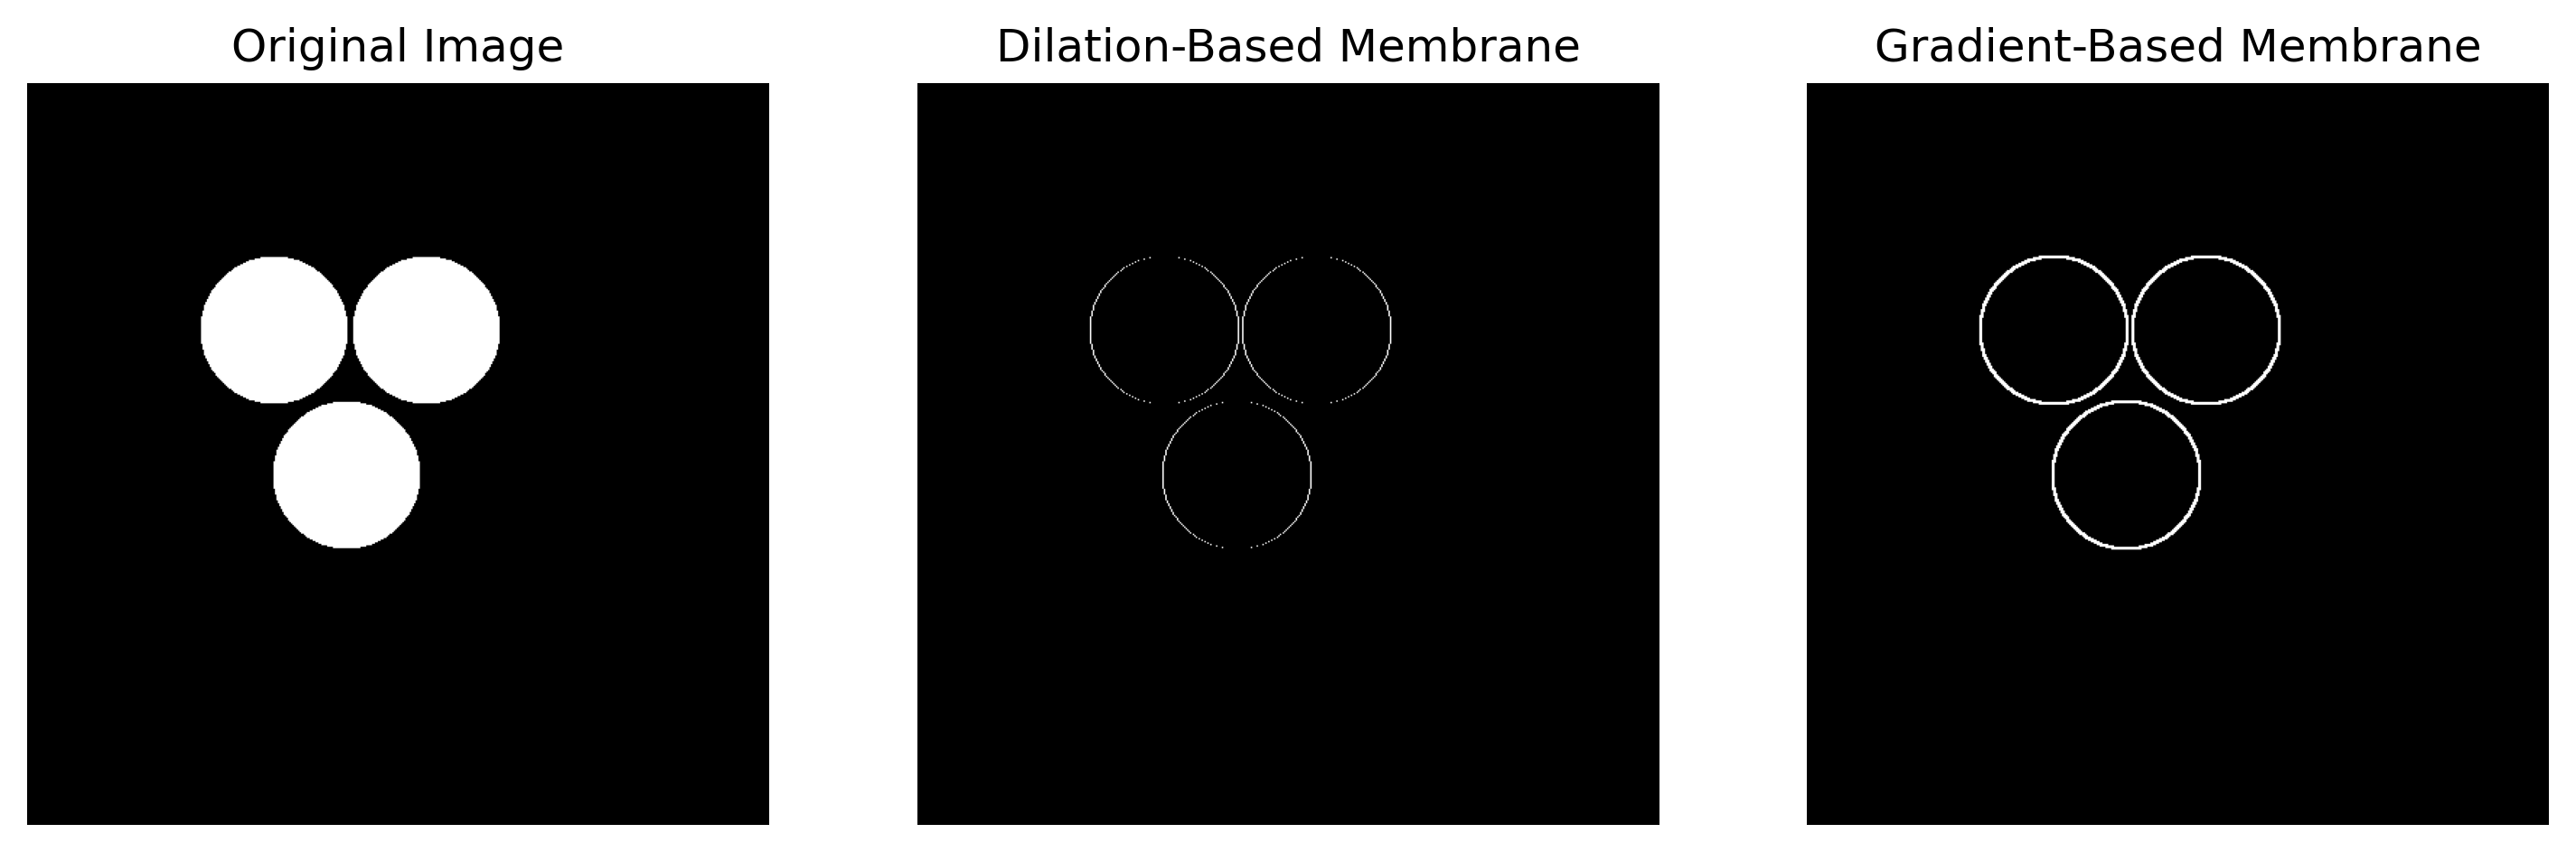

In [46]:
#Generate 3 disks
image = np.zeros((512, 512), dtype=np.uint8)
rr, cc = draw_disk((512//3, 512//3), 50, shape=image.shape)
rr2, cc2 = draw_disk((512//3, 512//3 + 105), 50, shape=image.shape)
rr3, cc3 = draw_disk((512//3 + 100, 512//3 + 50), 50, shape=image.shape)
image[rr, cc] = 255
image[rr2, cc2] = 255
image[rr3, cc3] = 255

#Extract membranes
image = binary_dilation(image, structure=disk(1))
membrane1 = extract_membrane(image)
membrane2 = extract_membrane_gradient(image)

#Plot disks
plt.subplots(1,3, figsize=(12,6), dpi=300)
plt.subplot(131)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.subplot(132)
plt.title("Dilation-Based Membrane")
plt.imshow(membrane1, cmap='gray')
plt.subplot(133)
plt.title("Gradient-Based Membrane")
plt.imshow(membrane2, cmap='gray')
[ax.axis("off") for ax in plt.gcf().axes]

### Contactome Validation

In [6]:
import pandas as pd
all_neuron_labels = np.arange(1, 180)  # Example neuron labels from 1 to 180
contactome_matrix = pd.DataFrame(0, index=all_neuron_labels, columns=all_neuron_labels, dtype=np.int32)

In [14]:
def _accumulate_undirected_pairs(mat: pd.DataFrame, a: np.ndarray, b: np.ndarray):
        """
        Given two same-length arrays a,b of neuron ids for adjacent pixels,
        accumulate counts into mat symmetrically for undirected pairs.
        """
        if a.size == 0:
            return

        lo = np.minimum(a, b).astype(int, copy=False)
        hi = np.maximum(a, b).astype(int, copy=False)

        pairs = np.stack([lo, hi], axis=1)
        print(pairs)
        uniq_pairs, counts = np.unique(pairs, axis=0, return_counts=True)
        print(uniq_pairs)
        print(counts)

        for (i, j), c in zip(uniq_pairs, counts):
            # i != j always by construction of adjacency mask, but keep safe
            if i == j:
                continue
            mat.at[i, j] += int(c)
            mat.at[j, i] += int(c)

In [19]:
_accumulate_undirected_pairs(contactome_matrix, np.array([1, 2, 3]), np.array([2, 3, 4]))

[[1 2]
 [2 3]
 [3 4]]
[[1 2]
 [2 3]
 [3 4]]
[1 1 1]


In [20]:
contactome_matrix

,1,2,3,4,5,6,7,8,9,10,...,170,171,172,173,174,175,176,177,178,179
1,0,6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,6,0,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
176,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
177,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
178,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
